# Ensemble phase picking (continuous waveform, full band)
- Yiyu Ni (niyiyu@uw.edu)
- Last updated: May 1, 2023

### import packages

In [1]:
import gc
import obspy
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ELEP/src/")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from ensemble_coherence import ensemble_semblance
from ensemble_statistics import ensemble_statistics
from trigger_func import picks_summary_simple
import seisbench.models as sbm
from tqdm import tqdm
from obspy.core.utcdatetime import UTCDateTime

pd.set_option('display.max_columns', None)

### Load data
We read mSEED from [PB.B204](https://ds.iris.edu/gmap/#network=PB&station=B204&planet=earth) station, Jan 6, 2023. The stream contains 10-hour 3-component waveform from EH channel (short period high-gain).

We read the number of data points in each trace, delta (reciprocal of sampling rate), and start time of the trace.

In [2]:
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

client = Client("IRIS")

3 Trace(s) in Stream:
UW.SHW..HHE | 2022-02-06T12:00:00.000000Z - 2022-02-06T23:59:59.990000Z | 100.0 Hz, 4320000 samples
UW.SHW..HHN | 2022-02-06T12:00:00.000000Z - 2022-02-06T23:59:59.990000Z | 100.0 Hz, 4320000 samples
UW.SHW..HHZ | 2022-02-06T12:00:00.000000Z - 2022-02-06T23:59:59.990000Z | 100.0 Hz, 4320000 samples


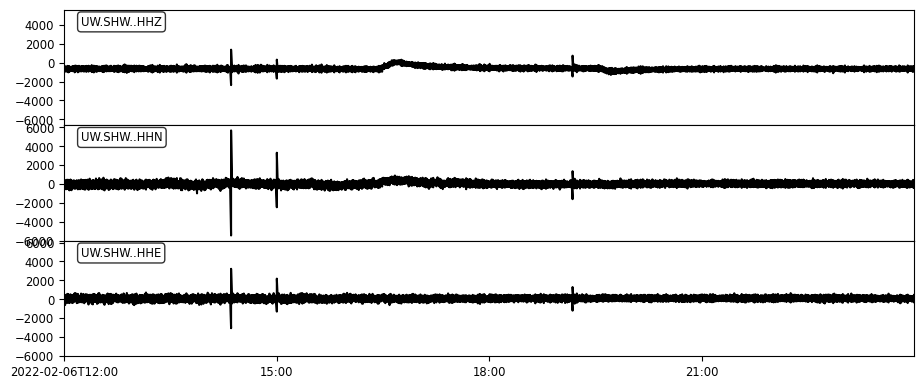

In [6]:
starttime = UTCDateTime("2022-02-06T12:00:00.000000")
endtime   = UTCDateTime("2022-02-06T23:59:59.999000")
s = client.get_waveforms("UW", "SHW", location = "*", channel = "HH?", 
                         starttime = starttime, endtime = endtime)
print(s)
npts = s[0].stats.npts
delta = s[0].stats.delta
starttime = s[0].stats.starttime

fig =plt.figure(figsize = (10, 4))
s.plot(fig = fig);

### Baseline using original pretrianed model

In [7]:
# cut continuous data into one-minute time window (6000 sample for EqTransformer)
# 3000 (50%, 30 seconds) sample overlap 
# mute 500 samples of prediction on both end of time window

twin = 6000
step = 3000
l_blnd, r_blnd = 500, 500
nseg = int(np.ceil((npts - twin) / step)) + 1

In [47]:
eqt = sbm.EQTransformer.from_pretrained('pnw')
eqt.to(torch.device("cuda"));
eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                 (only for window prediction models)', step)
eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                  each side of each window prediction', (l_blnd, r_blnd))
eqt.eval();
tf_learn = [int((i.peak_time - starttime)*100) for i in eqt.classify(s)[0]]
# print(len([print(i) for i in eqt.classify(s)[0]]))

## cut and predict on time windows
We cut the continuous data into small time windows with overlap. Then, we pre-process the stream and the windowed waveform: switch channel order, demean, normalization, and taper.

Note that `original` pretrain model use std normalization, while others use maximum normalization. Thus, we create two different windowed data: `windows_std` and `windows_max`.

In [9]:
s2 = eqt.annotate_stream_pre(s.copy(), argdict=eqt._annotate_args)
sdata = np.array(s2)[[2,1,0], :] #ENZ
# sdata: ZNZ

windows_std = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_max = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
_windows = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_idx = np.zeros(nseg, dtype=np.int32)
tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))

for iseg in range(nseg):
    idx = iseg * step
    _windows[iseg, :] = sdata[:, idx:idx + twin]
    _windows[iseg, :] -= np.mean(_windows[iseg, :], axis=-1, keepdims=True)
    # original use std norm
    windows_std[iseg, :] = _windows[iseg, :] / np.std(_windows[iseg, :]) + 1e-10
    # others use max norm
    windows_max[iseg, :] = _windows[iseg, :] / (np.max(np.abs(_windows[iseg, :]), axis=-1, keepdims=True) + 1e-10)
    windows_idx[iseg] = idx

windows_std[:, :, :6] *= tap; windows_std[:, :, -6:] *= tap[::-1]; 
windows_max[:, :, :6] *= tap; windows_max[:, :, -6:] *= tap[::-1];
del _windows

Then we use EqTransformer model to perform prediction on each of the time window. We use six different pre-trained model, listed in `pretrain_list`. We loop over these pretrain weights, and save the results in `batch_pred` variable of shape [2, 6, 1199, 6000]. Understanding the shape of this varibale is important:
- 2: one for P-wave and another for S-wave. We don't save detection branch.
- 6: six pretrained weights
- 1439: the number of time windows
- 6000: the number of points in each time window (60 sec@100 Hz)

In [10]:
pretrain_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'neic']

# dim 0: 0 = P, 1 = S
batch_pred = np.zeros([2, len(pretrain_list), nseg, twin], dtype = np.float32) 

for ipre, pretrain in enumerate(pretrain_list):
    print(pretrain)
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(torch.device("cuda"));
    eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                    (only for window prediction models)', step)
    eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                     each side of each window prediction', (l_blnd, r_blnd))
    eqt.eval();
    if pretrain == 'original':
        # batch prediction through torch model
        windows_std_tt = torch.Tensor(windows_std)
        _torch_pred = eqt(windows_std_tt.to(torch.device("cuda")))
    else:
        windows_max_tt = torch.Tensor(windows_max)
        _torch_pred = eqt(windows_max_tt.to(torch.device("cuda")))
    batch_pred[0, ipre, :] = _torch_pred[1].detach().cpu().numpy()
    batch_pred[1, ipre, :] = _torch_pred[2].detach().cpu().numpy()
    
# clean up memory
del _torch_pred, windows_max_tt, windows_std_tt, eqt
del windows_std, windows_max
gc.collect()
torch.cuda.empty_cache()
print(batch_pred.shape)

original
ethz
instance
scedc
stead
neic
(2, 6, 1439, 6000)


## stacking
This section we merge all time windows into the continuous prediction. We use the `stacking` function: it takes matrix of shape [nseg, ntrace] and merge it into an 1D array.

In [11]:
def stacking(data, npts, l_blnd, r_blnd):
    _data = data.copy()
    stack = np.full(npts, np.nan, dtype = np.float32)
    _data[:, :l_blnd] = np.nan; _data[:, -r_blnd:] = np.nan
    stack[:twin] = _data[0, :]
    for iseg in range(nseg-1):
        idx = step*(iseg+1)
        stack[idx:idx + twin] = \
                np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)
    return stack

We first merge results from each of the pretrained model, respectively.

In [12]:
pretrain_pred = np.zeros([2, len(pretrain_list), npts], dtype = np.float32)
for ipre, pretrain in enumerate(pretrain_list):
    # 0 for P-wave
    pretrain_pred[0, ipre, :] = stacking(batch_pred[0, ipre, :], npts, l_blnd, r_blnd)
    
    # 1 for S-wave
    pretrain_pred[1, ipre, :] = stacking(batch_pred[1, ipre, :], npts, l_blnd, r_blnd)

/tmp/ipykernel_3345643/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


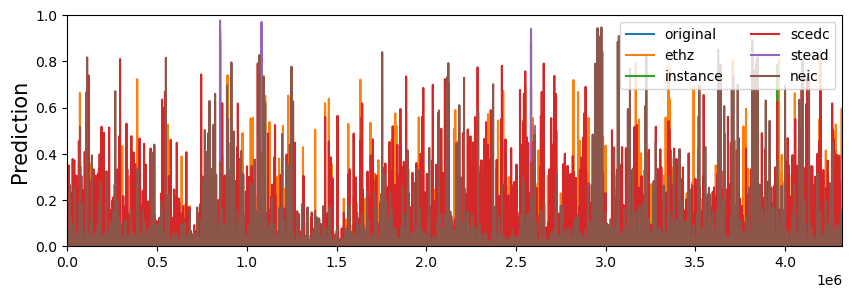

In [13]:
plt.figure(figsize = (10, 3))
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

## ensemble on time windows
We then apply the ensemble measurement on each of the time window, and then merge them.

In [14]:
paras_simple = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}

max_pred = np.zeros([2, nseg, twin], dtype = np.float32)
smb_pred = np.zeros([2, nseg, twin], dtype = np.float32)

In [15]:
## the semblance may takes a little bit to calculate
for iseg in tqdm(range(nseg)):
    # 0 for P-wave
    max_pred[0, iseg, :] = ensemble_statistics(batch_pred[0, :, iseg, :], paras_simple)
    smb_pred[0, iseg, :] = ensemble_semblance(batch_pred[0, :, iseg, :], paras_semblance)
    
    # 1 for P-wave
    max_pred[1, iseg, :] = ensemble_statistics(batch_pred[1, :, iseg, :], paras_simple)
    smb_pred[1, iseg, :] = ensemble_semblance(batch_pred[1, :, iseg, :], paras_semblance)

100%|██████████| 1439/1439 [02:09<00:00, 11.09it/s]


In [16]:
# 0 for P-wave
max_p = stacking(max_pred[0, :], npts, l_blnd, r_blnd)
smb_p = stacking(smb_pred[0, :], npts, l_blnd, r_blnd)

# 1 for P-wave
max_s = stacking(max_pred[1, :], npts, l_blnd, r_blnd)
smb_s = stacking(smb_pred[1, :], npts, l_blnd, r_blnd)

# clean-up RAM
del max_pred, smb_pred, batch_pred

/tmp/ipykernel_3345643/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


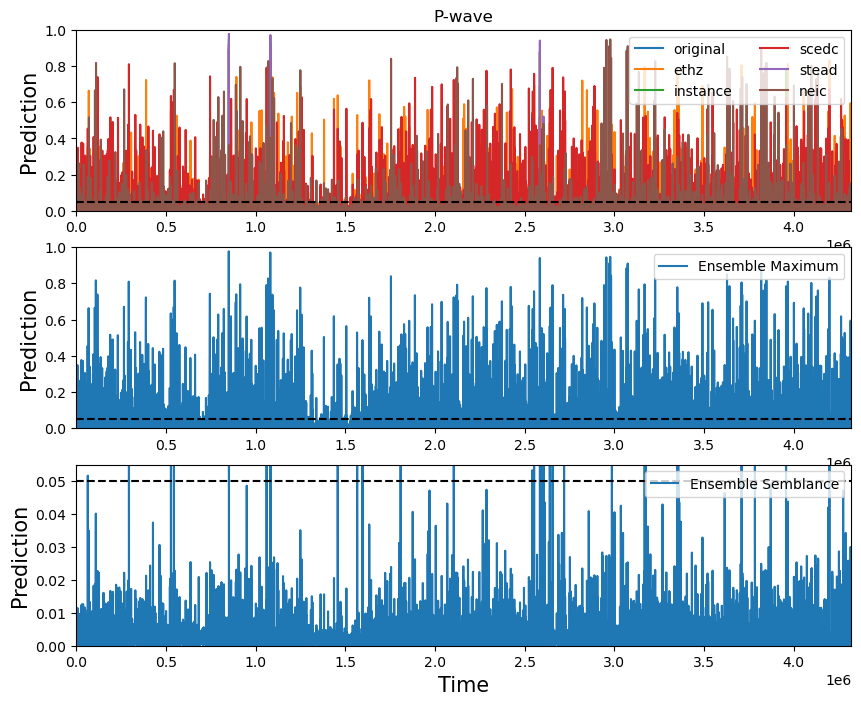

In [17]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("P-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_p, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_p, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, .055]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

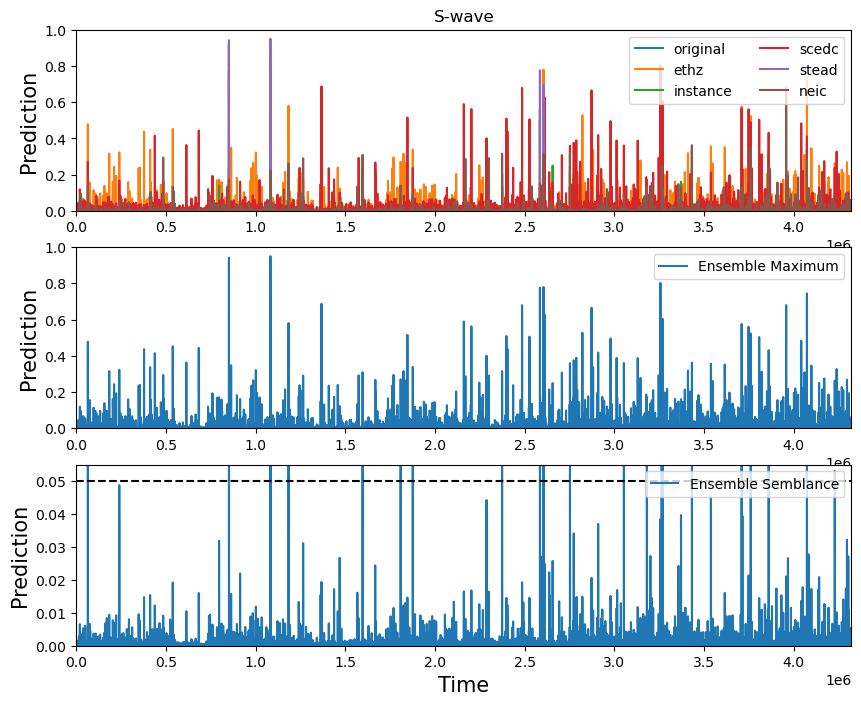

In [19]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("S-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[1, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_s, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_s, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, .055]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

## trigger and picking

In [20]:
## all picks for this station and this day by PNSN
pnsn = pd.read_csv("./data/UW.SHW.2022.037.csv")
pnsn = pnsn[pnsn['phase'] == 'P']

In [23]:
pnsn

,pick_id,source_id,network,station,location,channel,timestamp,year,month,day,doy,hour,minute,second,microsecond,phase,evaluation_mode,onset,polarity,uncertainty,backazimuth,contributor
0,1893933,uw61815141,UW,SHW,--,HHZ,1.644114e+09,2022,2,6,37,2,14,59,730000,P,manual,im,un,0.06,72.538,UW
1,1893727,uw61815151,UW,SHW,--,HHZ,1.644115e+09,2022,2,6,37,2,31,28,850000,P,manual,em,un,0.15,279.673,UW
2,1893483,uw61815186,UW,SHW,--,HHZ,1.644138e+09,2022,2,6,37,9,3,56,770000,P,manual,em,un,0.15,280.703,UW
3,1893629,uw61815216,UW,SHW,--,HHZ,1.644157e+09,2022,2,6,37,14,21,48,280000,P,manual,im,ne,0.03,85.576,UW
4,1893198,uw61815221,UW,SHW,--,HHZ,1.644160e+09,2022,2,6,37,15,0,21,750000,P,manual,im,un,0.06,85.311,UW
6,1893386,uw61815251,UW,SHW,--,HHZ,1.644175e+09,2022,2,6,37,19,10,42,180000,P,manual,em,un,0.15,81.476,UW


/tmp/ipykernel_3345643/2682774566.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10, 2))


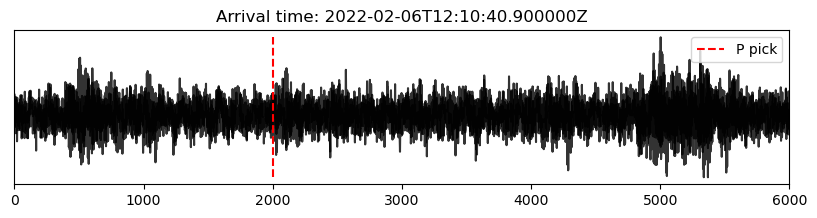

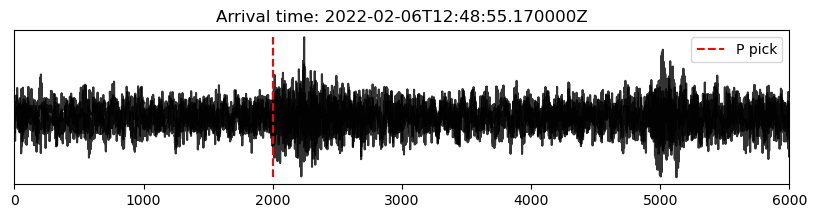

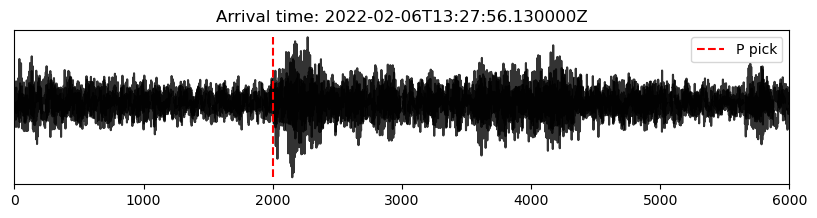

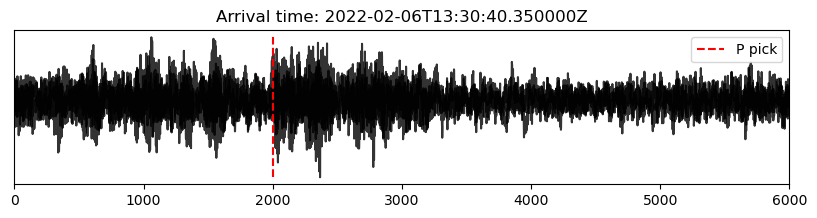

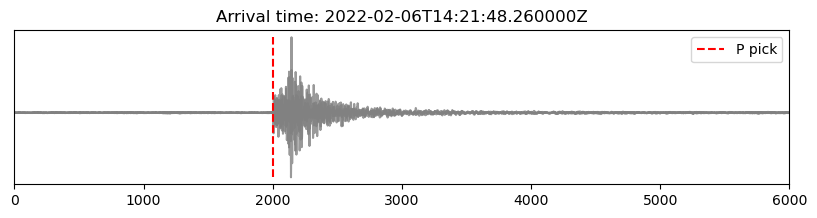

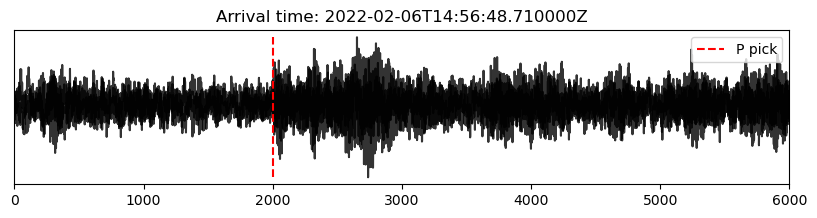

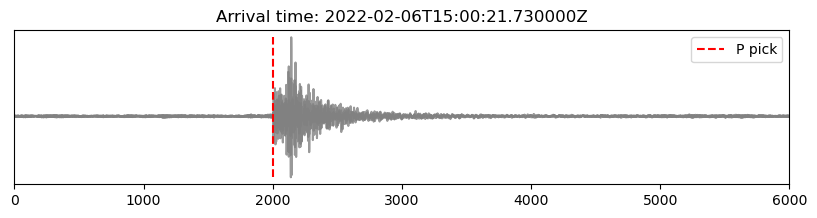

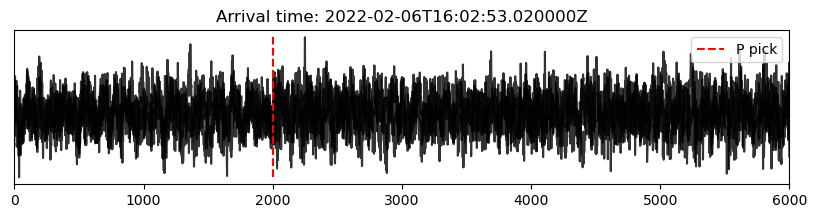

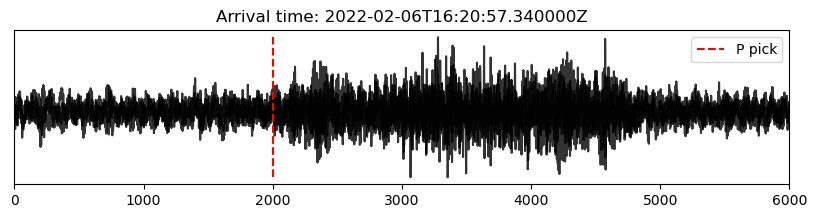

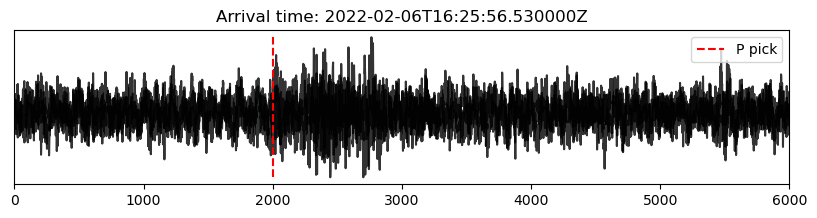

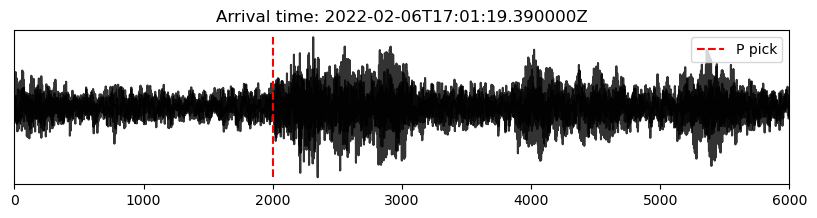

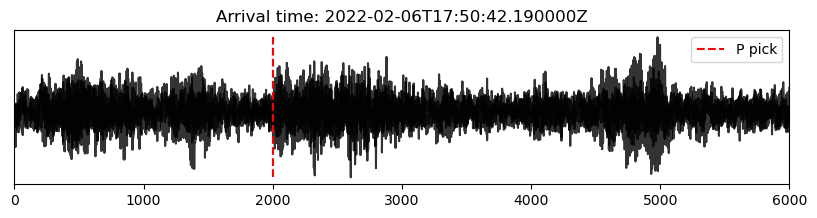

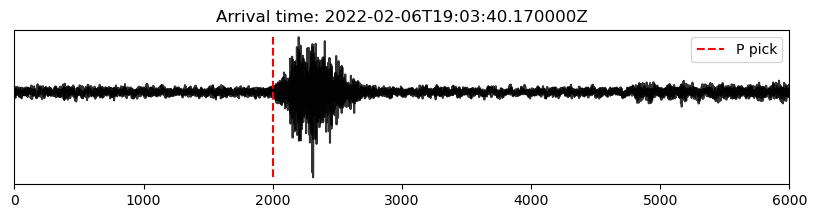

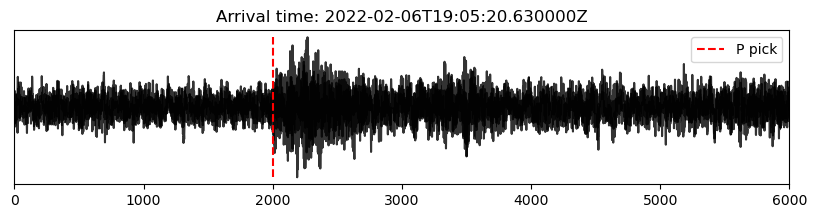

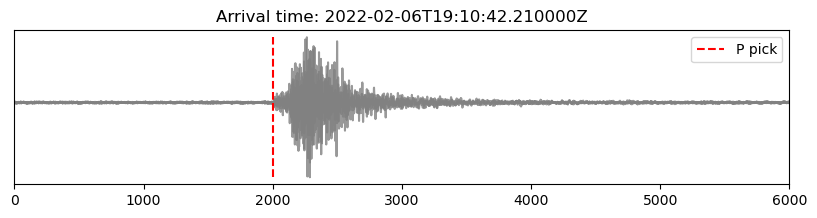

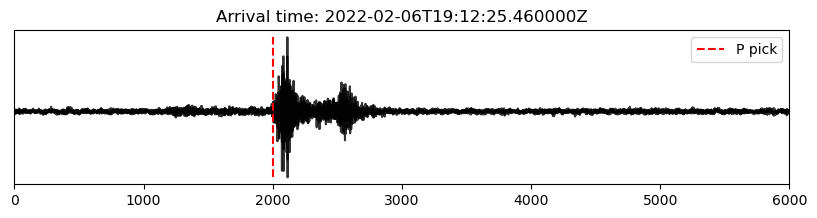

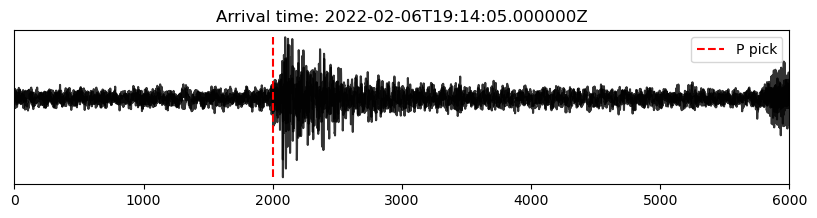

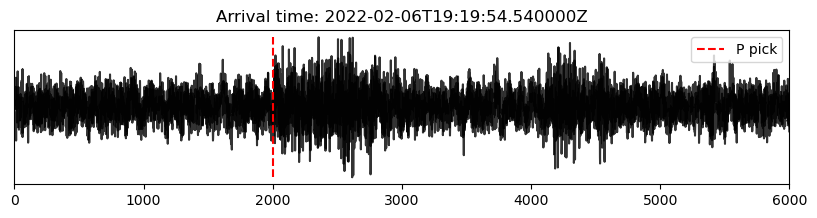

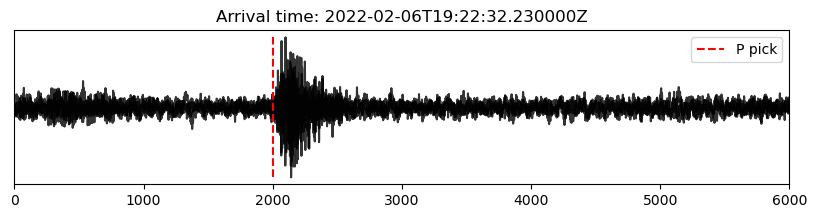

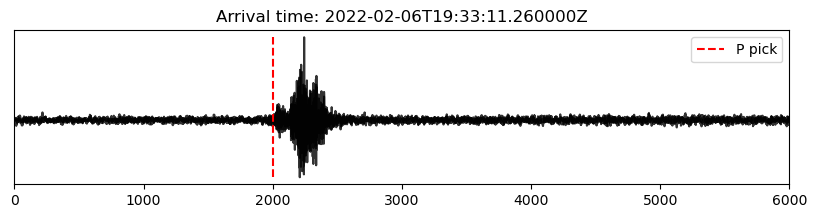

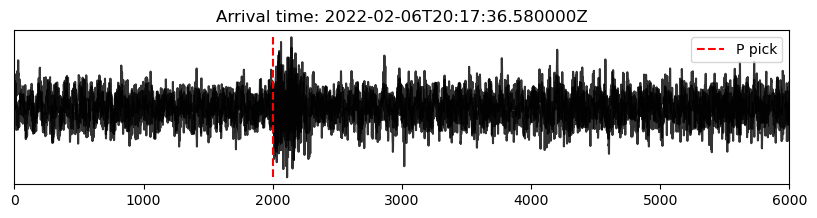

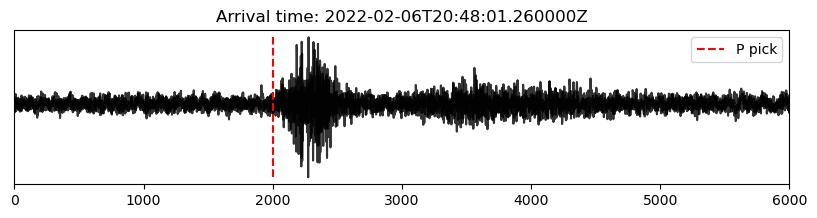

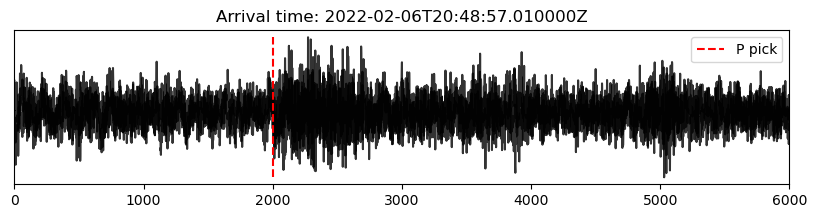

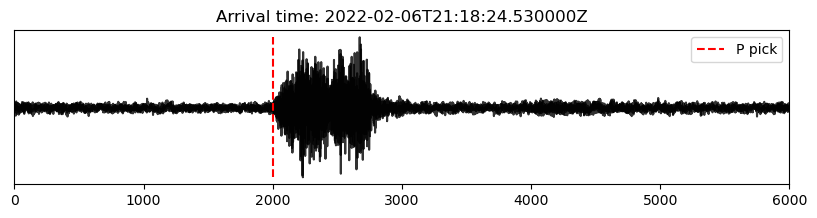

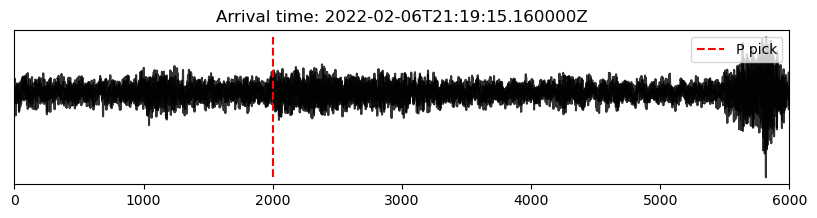

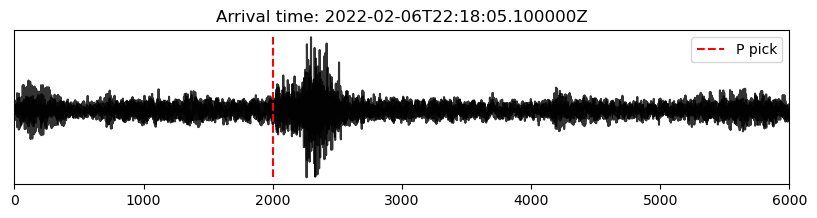

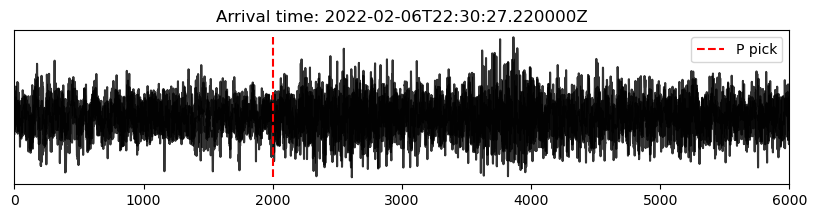

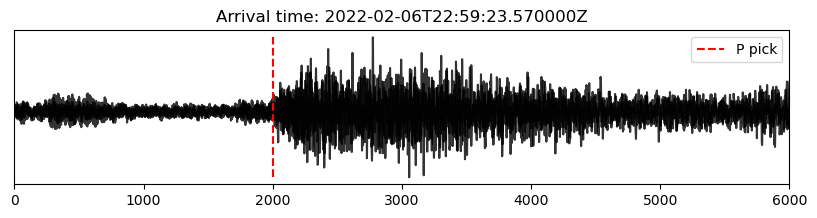

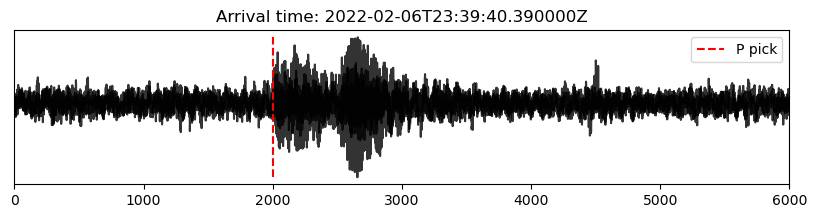

In [22]:
## gray waveform: there is a pick by PNSN within 1 second
## black waveform: probably a new event detected

# p_index = picks_summary_simple(smb_p, 0.05)
p_index = tf_learn
for idx in p_index:
    arrival_utc = starttime + idx * delta
    plt.figure(figsize = (10, 2))
    w = sdata[:, idx-2000:idx+4000]
    if (abs(arrival_utc.timestamp - pnsn['timestamp']) < 1).any():
        
        plt.plot(w.T, color = 'gray', alpha = 0.8)
    else:
        plt.plot(w.T, color = 'black', alpha = 0.8)
    plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', label = 'P pick')
    plt.title(f"Arrival time: {arrival_utc}")
    plt.yticks([]); plt.legend(loc = 'upper right')
    plt.xlim([0, 6000])

# EOF